In [6]:
%%capture --no-stderr
%pip install langgraph langchain-google-genai langchain-community langchain-core tavily-python

In [7]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "learn_agentic_ai"

In [8]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, AnyMessage
from langchain.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import Annotated, List, Literal
from typing_extensions import TypedDict
from IPython.display import Image, display

memory = MemorySaver()

class State(TypedDict):
    query: str
    messages: Annotated[List[AnyMessage], add_messages]
    category: str
    sentiment: str
    human_feedback: str

@tool
def get_order_update() -> str:
    """Retrieves the latest update on a customer's order.

    Returns:
        A string containing the order update.
    """
    return "Your order ID is 1234 and it has been shipped."

@tool
def get_delivery_status() -> str:
    """Retrieves the current delivery status of a customer's order.

    Returns:
        A string containing the delivery status information.
    """
    return "Your package is in transit and will arrive by 2024-01-01."

@tool
def get_feedback_complaints() -> str:
    """Handles customer feedback and complaints.

    Returns:
        A string acknowledging the feedback or complaint.
    """
    return "Thank you for your feedback. We’ll work on improving our service."

@tool
def get_product_information() -> str:
    """Provides information about a specific product.

    Returns:
        A string containing product information.
    """
    return "This product is a top-selling item with excellent reviews."

tools = [
    get_order_update,
    get_delivery_status,
    get_feedback_complaints,
    get_product_information
]

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(api_key=GEMINI_API_KEY, model="gemini-2.0-flash-exp")

llm_with_tools = llm.bind_tools(tools)

In [9]:
def categorize_and_analyze_sentiment(state: State) -> Command[Literal["assistant", "escalate"]]:
    """
    Determines the category and sentiment of the customer query.

    Categories:
    - Order Issues
    - Delivery Status
    - Product Information
    - Feedback / Complaints
    - General

    Sentiments:
    - Positive
    - Neutral
    - Negative
    """
    print("categorize_and_analyze_sentiment node is working")

    class CategorizeAndSentimentOutput(BaseModel):
        category: str = Field(description="Predefined category of the query. Options: Order Issues, Delivery Status, Product Information, Feedback / Complaints, General.")
        sentiment: str = Field(description="The sentiment of the query: Positive, Neutral, or Negative")

    structured_llm = llm_with_tools.with_structured_output(CategorizeAndSentimentOutput)

    prompt = ChatPromptTemplate.from_template(
        """Categorize the following customer query into one of these categories:
        - Order Issues
        - Delivery Status
        - Product Information
        - Feedback / Complaints
        - General

        Analyze the sentiment as Positive, Neutral, or Negative.

        The user message is: {query}
        """
    )
    output = structured_llm.invoke(prompt.format(query=state["query"]))

    goto = "escalate" if output.sentiment == "Negative" else "assistant"

    return Command (
        update={"category": output.category, "sentiment": output.sentiment},
        goto=goto
    )

def assistant(state: State) -> State:
    system_msg = f"""
    You are a friendly and helpful customer support assistant.
    You are here to assist customers with their inquiries and resolve their issues efficiently and effectively.
    Always prioritize understanding the customer's needs and providing clear, concise, and accurate information.

    Based on the query, use the avaiable tools or
    generate a response directly.

    Available tools:
    - get_order_update: Retrieves the latest update on a customer's order.
    - get_delivery_status: Retrieves the current delivery status of a customer's order.
    - get_feedback_complaints: Handles customer feedback and complaints.
    - get_product_information: Provides information about a specific product.

    Important: If the sentiment is negative, do not use any tools because the escalate node will do the job.

    Important: If the user's query is off-topic or unrelated to customer support, politely guide them back to the main topic by saying something like: "I understand your concern, but I'm here to help with customer support related questions. Could you please rephrase your query or ask a question related to our products or services?
    """

    user = f"""
    The customer query is: {state["query"]}
    The customer's query is categorized as: {state["category"]}
    The sentiment of the query is: {state["sentiment"]}"""

    response = llm_with_tools.invoke([SystemMessage(content=system_msg), HumanMessage(content=user)])


    return Command (
        update={"messages": response},
        )

def escalate(state: State) -> Command[Literal[END]]:
    """
    Escalates the query to a human agent when the sentiment is negative.
    """
    return Command(
        update={"human_feedback": "Escalated to human agent due to negative sentiment."},
        goto=END
    )

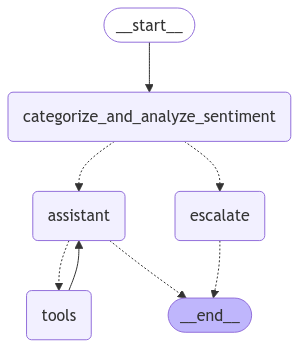

In [10]:
  graph_builder = StateGraph(State)

  graph_builder.add_node("categorize_and_analyze_sentiment", categorize_and_analyze_sentiment)
  graph_builder.add_node("assistant", assistant)
  graph_builder.add_node("tools", ToolNode(tools))
  graph_builder.add_node("escalate", escalate)

  graph_builder.add_edge(START, "categorize_and_analyze_sentiment")
  graph_builder.add_conditional_edges("assistant", tools_condition)
  graph_builder.add_edge("tools", "assistant")

  graph = graph_builder.compile(checkpointer=memory)

  display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
config = {"configurable": {"thread_id": 1}}

def stream_graph_updates(user_input: str):
    for event in graph.stream({"query": user_input}, config):
      print(event)
        # for node_name, value in event.items():
        #     if node_name == "assistant":
        #         print("Assistant:", value["messages"].content)
        #     elif node_name == "escalate":
        #         print("Escalation:", value["human_feedback"])
        #     elif node_name == "categorize_and_analyze_sentiment":
        #         print("Category:", value["category"])
        #         print("Sentiment:", value["sentiment"])
        #     else:
        #         print("Other node output:", value)


while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input)

User: Hi
categorize_and_analyze_sentiment node is working
{'categorize_and_analyze_sentiment': {'category': 'General', 'sentiment': 'Neutral'}}
{'assistant': {'messages': AIMessage(content='Hello! How can I assist you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-e074d838-35c0-4b43-b37c-602c30965894-0', usage_metadata={'input_tokens': 460, 'output_tokens': 10, 'total_tokens': 470, 'input_token_details': {'cache_read': 0}})}}
User: Why is the sky blue ?
categorize_and_analyze_sentiment node is working
{

{'assistant': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_delivery_status', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-50bf5f6a-c310-4dff-a30f-13ced71b2a21-0', tool_calls=[{'name': 'get_delivery_status', 'args': {}, 'id': '990fdf32-2d6d-44cd-ab2b-9efe33704319', 'type': 'tool_call'}], usage_metadata={'input_tokens': 468, 'output_tokens': 5, 'total_tokens': 473, 'input_token_details': {'cache_read': 0}})}}
{'tools': {'messages': [ToolMessage(content='Your package is in tra

ResourceExhausted: 429 Resource has been exhausted (e.g. check quota).

In [ ]:
# def test_langgraph_agent(query: str):
#     initial_state = {
#         "messages": [HumanMessage(content=query)],
#         "category": "",
#         "sentiment": "",
#         "response": ""
#     }

#     output = graph.invoke(initial_state)

#     print("Query:", query)
#     print("Category:", output["category"])
#     print("Sentiment:", output["sentiment"])
#     print("Response:", output["response"])

# test_queries = [
#     "I need help with a refund for my order.",
#     "When will my package arrive?",
#     "Can you provide more details about this product?",
#     "I have a complaint about the quality of the product.",
#     "What are your business hours?",
#     "The delivery time mentioned seems incorrect, can you confirm?",
#     "I am unhappy with the response I received from customer service.",
# ]

# for query in test_queries:
#     print("\n--- Testing Query ---")
#     test_langgraph_agent(query)